# Gaussian Process Surrogate Modeling for Molecular Dynamics Optimization

## Imports and Functions

In [102]:
# Math Packages
import numpy as np
import torch as torch
from scipy import interpolate
from scipy.optimize import minimize
import time as time
import pandas as pd

# Plotting
import matplotlib.pyplot as plt  
from matplotlib.pyplot import figure
from matplotlib import cm
#matplotlib format
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})
rc('mathtext',**{'default':'regular'})
get_ipython().run_line_magic('matplotlib', 'inline')
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'")

# Data saving packages
from pickle import dump, load
import itertools

# Parallelization
from dask import config as cfg
import dask
from dask.distributed import Client, progress
from multiprocessing import Pool
import multiprocessing as mp
import os
#mp.set_start_method('fork')
#os.environ["OMP_NUM_THREADS"] = "1" 

In [2]:
def se_kernel(x1, x2, l, width):
    """
    Computes the squared exponential kernel between the tensors x and y with hyper-parameters l and width.
    N corresponds to the number of samples and D corresponds to the number of dimensions of the input function.
    
    Parameters
    ----------
    
    x: Tensor [N,D]
        Feature vector for N samples with D dimensions each
    
    y: Tensor [N,D]
        Feature vector for N samples with D dimensions each
        
    l: Tensor [D]
        Lengthscale hyper parameter
        
    width: Float
        Width hyper parameter
    """
    K = width**2 * torch.exp(-(torch.cdist(x1/l,x2/l,p=2)**2)/2)
    return K

def surrogate(Xi, Xd, l, width, y, KddInv):
    """
    Computes the gaussian process estimate of the structure factor given a set of pair potential parameters. 
    
    Parameters
    ----------
    
    Xi: Tensor [η*M,D]
        Feature vector for M potential samples at η r evaluations with D dimensions each. This 
        corresponds to the points you wish to infer.
    
    Xd: Tensor [N,D]
        Feature vector for N samples with D dimensions each. This corresponds to the points you trained on.
        
    l: Tensor [D]
        Lengthscale hyper parameter.
        
    width: Float
        Width hyper parameter
        
    y: Tensor [N,1]
        Output feature vector corresponding to the Xd training set.  
        
    KddInv: Tensor [N,N]
        This is the inverted kernel matrix of the training set Xd
       
    Returns
    -------
       
    μ: Tensor [η,N]
        The mean estimate for each g(r,n,sigma,epsilon) given in Xi. 
        
    """
    Kid = se_kernel(Xi, Xd, l, width)
    return 1 +  (Kid @ KddInv @ (y-1))

def local_surrogate(Xi, Xd, l, width, y, KddInv):
    """
    Computes the subset gaussian process estimate of the structure factor given a set of pair potential parameters. 
    
    Parameters
    ----------
    
    Xi: Tensor [M,D]
        Feature vector for M samples with D dimensions each. This corresponds to the points you wish to infer.
    
    Xd: Tensor [M,D]
        Feature vector for N samples with D dimensions each. This corresponds to the points you trained on.
        
    l: Tensor [D]
        Lengthscale hyper parameter.
        
    width: Float
        Width hyper parameter
        
    KddInv: Tensor [N,N]
        This is the inverted kernel matrix of the training set Xd
        
    Returns
    -------
    
    μ: Tensor [η,N]
        The mean estimate for each g(r) at each potential. The g(r)'s are organized in vertical lines where the column
        dimension indexes the potential parameters. 
        
    """
    Kid = se_kernel(Xi, Xd, l, width)
    return (1 +(Kid @ KddInv) @ (y-1)).T

## Importing the training data

In [3]:
# Import the training data generated by 1_sample_gen.ipynb

rmin = 0.0118331810091873
rmax = 15.512161254882812
rnum = 73

k   = 3.29982916e-27 #boltzmann constant,   [kcal/K/particle]   
av  = 6.0223e23      #avagadro number,      [particle/mol]  
T   = 42.2           #temperature,          [K]
kbT = k * av * T

input_dict = load(open('training_data/xs.p', 'rb'))
xd = input_dict['xs'].reshape(3*320,3)

input_dict = load(open('training_data/rdfs.p', 'rb'))
model_rdf = input_dict['rdfs']

gsd_fname = 'training_data/iter_0/traj/mie0.gsd'
import freud
import gsd.hoomd
bins=rnum
# Reads in traj and creates box from it
traj = gsd.hoomd.open(gsd_fname, 'r')
box = freud.box.Box.from_box(traj[0].configuration.box[:3])

# Establish RDF object to continually add frames into
rdf = freud.density.RDF(bins=bins, r_min = rmin, r_max=rmax)
for frame in traj:
    rdf.compute(system=(box,frame.particles.position), reset=False)
    
r = torch.tensor(rdf.bin_centers)

Old length:  155
New length:  73


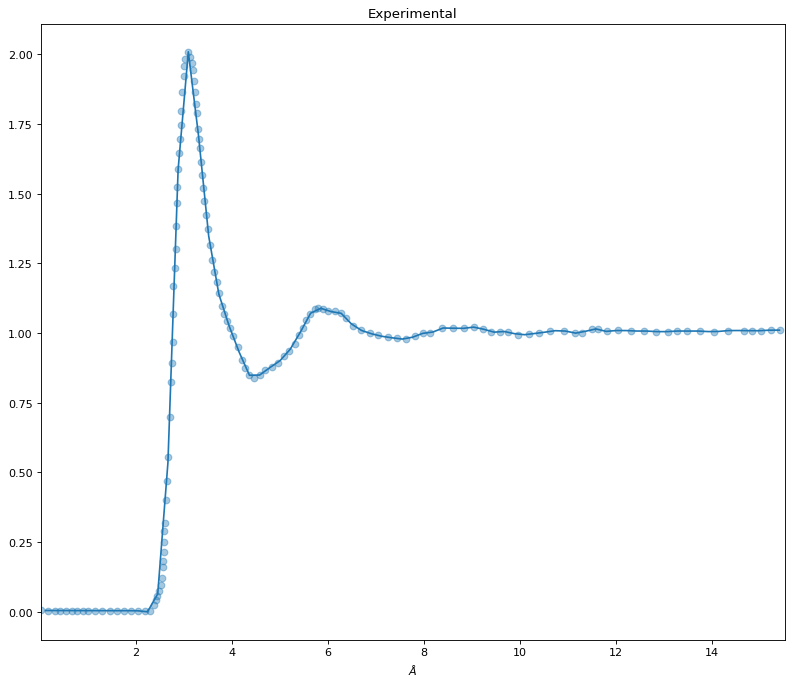

In [4]:
experimentalCSVFilename = 'exp_data/ne_42K_rdf.csv'

data = pd.read_csv(experimentalCSVFilename)
r_exp_raw = np.array(data['r'])
rdf_exp_raw = np.array(data[' g'])

rmin = 0.0118331810091873
rmax = 15.512161254882812
rnum = 73

# Interpolalate the experimental data to make it consistent with the simulations
rdf_exp_i = interpolate.splrep(r_exp_raw, rdf_exp_raw, s=0)
rdf_exp = torch.from_numpy(interpolate.splev(r, rdf_exp_i, der=0))

print("Old length: ", len(r_exp_raw))
print("New length: ", len(r))

figure(figsize = (12,10),dpi=80)
plt.title("Experimental")
plt.scatter(r_exp_raw,rdf_exp_raw,alpha=0.4)
plt.plot(r, rdf_exp)
plt.xlim(rmin,rmax)
plt.xlabel("$\AA$")
plt.show()

In [5]:
r, model_rdf.size()

(tensor([ 0.1180,  0.3303,  0.5427,  0.7550,  0.9673,  1.1797,  1.3920,  1.6043,
          1.8167,  2.0290,  2.2413,  2.4537,  2.6660,  2.8783,  3.0907,  3.3030,
          3.5153,  3.7277,  3.9400,  4.1523,  4.3647,  4.5770,  4.7893,  5.0017,
          5.2140,  5.4263,  5.6387,  5.8510,  6.0633,  6.2757,  6.4880,  6.7003,
          6.9127,  7.1250,  7.3373,  7.5497,  7.7620,  7.9743,  8.1867,  8.3990,
          8.6113,  8.8237,  9.0360,  9.2483,  9.4607,  9.6730,  9.8853, 10.0977,
         10.3100, 10.5223, 10.7347, 10.9470, 11.1593, 11.3717, 11.5840, 11.7963,
         12.0087, 12.2210, 12.4333, 12.6457, 12.8580, 13.0703, 13.2827, 13.4950,
         13.7073, 13.9197, 14.1320, 14.3443, 14.5567, 14.7690, 14.9813, 15.1937,
         15.4060], dtype=torch.float64),
 torch.Size([960, 73]))

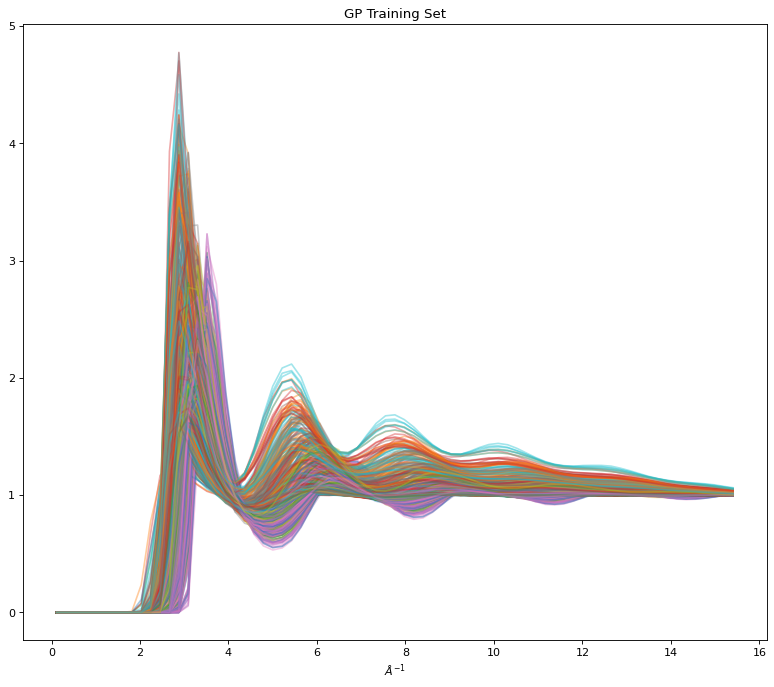

In [6]:
#Visualization of training set

figure(figsize = (12,10),dpi=80)
plt.title("GP Training Set")
for i in range(len(model_rdf)):
    plt.plot(r,model_rdf[i],alpha=0.4)
plt.xlabel("$\AA^{-1}$")
plt.show()

# fig, axs = plt.subplots(2, 2, figsize=(14, 8))
# plt.suptitle('Potential Parameter Distributions')
# axs[0,0].scatter(xd[:, 0], xd[:, 1],label="Samples")
# axs[0,0].set_xlabel('n')
# axs[0,0].set_ylabel('σ')
# axs[0,1].scatter(xd[:, 0], xd[:, 2],label="Samples")
# axs[0,1].set_xlabel('n')
# axs[0,1].set_ylabel('ϵ')
# axs[1,0].scatter(xd[:, 1], xd[:, 2],label="Samples")
# axs[1,0].set_xlabel('σ')
# axs[1,0].set_ylabel('ϵ')
# plt.show()

## Basic Matricies for GP Calculations

In [7]:
n = len(xd)
η = len(r)
XdClassic = torch.zeros(n*η,4)
yClassic = torch.zeros(n*η)

k = 0 # Row index in Xd matrix and y vector.
for i in range(n):
    for j in range(η):
        # Xd_k = (n,σ,ϵ,q)
        XdClassic[k] = torch.tensor([xd[i][0],xd[i][1],xd[i][2],r[j]])
        yClassic[k] = model_rdf[i][j]
        k += 1
        
yClassic = torch.unsqueeze(yClassic,dim=0).transpose(0,1)

# Remake the Xd matrix for the subset matrix 
Xd = torch.tensor(xd).float()
y = model_rdf.float()

index = torch.arange(0,len(xd),1)

/scratch/local/u1262705/237179/ipykernel_171026/2271762895.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Xd = torch.tensor(xd).float()


## Choosing the hyper parameters based off LOO and LMLH

In [8]:
def g_i(i, θ):
    
    l = torch.tensor([θ[0],θ[1],θ[2]]).float()
    w = torch.tensor(θ[3]).float()
    σn = torch.tensor(θ[4]).float()
    
    Kdd = se_kernel(Xd,Xd,l,w) + torch.eye(len(Xd))*σn
    L = torch.linalg.cholesky(Kdd) # Extract Cholesky decomposition
    KddInv = torch.cholesky_inverse(L) 
    
    qN = KddInv @ y.T[i]
    
    KddInv_ii = torch.diagonal(KddInv, 0)
    
    qNover       = qN/torch.sqrt(KddInv_ii)
    logKddInv_ii = torch.log(KddInv_ii)
    
    g = (1/(2*len(Xd)))*(qNover@qNover) - (1/(2*len(Xd)))*torch.sum(logKddInv_ii) + (1/2)*np.log(2*np.pi)
    
    return g

def g(θ):
    
    l = torch.tensor([θ[0],θ[1],θ[2]]).float()
    w = torch.tensor(θ[3]).float()
    σn = torch.tensor(θ[4]).float()
    
    Kdd = se_kernel(Xd,Xd,l,w) + torch.eye(len(Xd))*σn
    KddInv = torch.linalg.inv(Kdd)
    
    KddInv_ii = torch.diagonal(KddInv, 0)
    
    logKddInv_ii = torch.log(KddInv_ii)
    
    g = (1/(2*len(Xd)))*torch.sum(((KddInv @ y).T/(torch.sqrt(KddInv_ii).repeat(73,1)))**2) - (73/(2*len(Xd)))*torch.sum(logKddInv_ii) + (73/2)*np.log(2*np.pi)
    
    return g

In [9]:
def compute_loo(hyperParamOptions,j_0, j_last):
    
    looμArr = torch.zeros((j_last - j_0,len(Xd),len(r))) 
    
    for j in range(j_0,j_last,1):

        # Calculate Kdd for local GP with hyper parameter index j
        arr = hyperParamOptions[j]
        l = torch.tensor([arr[0],arr[1],arr[2]]).float()
        w = torch.tensor(arr[3]).float()
        σn = torch.tensor(arr[4]).float()
        Kdd = se_kernel(Xd,Xd,l,w) + torch.eye(len(Xd))*σn
    
        looμArr_j = torch.zeros(len(Xd),len(r))
    
        # Leave index i out from training and predict it using Local GP
        for i in range(len(Xd)): 
    
            Kdd_i = Kdd[index[index != i]].T[index[index != i]].T
            KddInv_i = torch.linalg.inv(Kdd_i)
    
            # Remove the same values from y
            y_i = y[index != i]
    
            # Again for X data
            Xd_i = Xd[index[index != i]]
            Xi = Xd[i].unsqueeze(dim=0)
    
            # Compute the predictions after leaving one out
            looμ = local_surrogate(Xi,Xd_i,l,w,y_i,KddInv_i).T
            looμArr_j[i] = looμ
        
        looμArr[j - j_0] = looμArr_j

    output_dict = dict(looμArr = looμArr, hyperParamOptions = hyperParamOptions[j_0:j_last])
    dump(output_dict, open('training_data/hyperparameter/Ideal/hyperParams'+str(j_0)+'.p', 'wb'))

    return looμArr, hyperParamOptions

In [10]:
cfg.set({'distributed.scheduler.worker-ttl': None}) # This stops dask from crying when the sims take a long time.
client = Client(n_workers=80)
# https://ondemand.chpc.utah.edu/rnode/notch148.ipoib.int.chpc.utah.edu/8787/status
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 80
Total threads: 80,Total memory: 187.40 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44613,Workers: 80
Dashboard: http://127.0.0.1:8787/status,Total threads: 80
Started: Just now,Total memory: 187.40 GiB
Comm: tcp://127.0.0.1:33549,Total threads: 1
Dashboard: http://127.0.0.1:33583/status,Memory: 2.34 GiB
Nanny: tcp://127.0.0.1:41467,


In [11]:
try:
    print("Attempting to load previously calculated hyper parameters")
    
    from pickle import load
    input_dict = load(open('training_data/hyperparameterG/Ideal/hyperParams.p', 'rb'))
    results = input_dict['results']
    hyperParamOptions = input_dict['hyperParamOptions']
    print("Success!!!")
    
except:
    print("Failed")
    
    ℓ_nmin = 0.5
    ℓ_nmax = 4
    
    ℓ_σmin = 0.01
    ℓ_σmax = 0.05
    
    ℓ_ϵmin = 0.001
    ℓ_ϵmax = 0.01
    
    w_min = 1e-4
    w_max = 1e-1
    
    σn_min = 1e-4
    σn_max = 1e-2
    
    
    # Creates a set of hyper parameters to compare
    trials = 5_000
    hyperParamOptions = torch.zeros((trials,5))
    hyperParamOptions[:,0] = (ℓ_nmax - ℓ_nmin) * torch.rand(trials) + ℓ_nmin
    hyperParamOptions[:,1] = (ℓ_σmax - ℓ_σmin) * torch.rand(trials) + ℓ_σmin
    hyperParamOptions[:,2] = (ℓ_ϵmax - ℓ_ϵmin) * torch.rand(trials) + ℓ_ϵmin
    hyperParamOptions[:,3] = (w_max  - w_min)  * torch.rand(trials) + w_min
    hyperParamOptions[:,4] = (σn_max - σn_min) * torch.rand(trials) + σn_min

    # Queue up function calls into dask
    lazy_results = []
    for i in range(trials):
        lazy_results.append(dask.delayed(g)(hyperParamOptions[i]))

    print("Queued Lazy Results")

    results = dask.compute(*lazy_results)
        
    output_dict = dict(results = results, hyperParamOptions = hyperParamOptions) # logMarginalLHArr = logMarginalLHArr
    dump(output_dict, open('training_data/hyperparameterG/Ideal/hyperParams.p', 'wb'))
    
    print("Done")

Attempting to load previously calculated hyper parameters
Success!!!


In [12]:
torch.argmin(torch.tensor(results))

tensor(1310)

In [13]:
hyperParamOptions[torch.argmin(torch.tensor(results))]

tensor([3.5815e+00, 4.8367e-02, 9.3155e-03, 9.4958e-02, 8.2605e-04])

In [14]:
try:
    print("Attempting to load previously calculated hyper parameters")
    
    from pickle import load
    input_dict = load(open('training_data/hyperparameter/Ideal/hyperParams.p', 'rb'))
    results = input_dict['results']
    hyperParamOptions = input_dict['hyperParamOptions']
    print("Success!!!")
    
except:
    print("Failed")
    
    # Creates a set of hyper parameters to compare
    trials = 5_000
    hyperParamOptions = torch.zeros((trials,5))
    hyperParamOptions[:,0] = (12   - 0.1) * torch.rand(trials) + 0.1
    hyperParamOptions[:,1] = (0.6  - 0.001) * torch.rand(trials) + 0.001
    hyperParamOptions[:,2] = (0.2  - 0.01) * torch.rand(trials) + 0.01
    hyperParamOptions[:,3] = (0.08 - 0.0001) * torch.rand(trials) + 0.0001
    hyperParamOptions[:,4] = (0.01 - 0.00000001) * torch.rand(trials) + 0.00000001

    # Storage for the leave one out prediction of local GP
    looμArr = torch.zeros((len(hyperParamOptions),len(Xd),len(r))) 
    
    # Queue up function calls into dask
    lazy_results = []
    for i in range(int(trials/50)):
        j_0 = (i*50)
        j_last = ((i+1)*50)
        lazy_results.append(dask.delayed(compute_loo)(hyperParamOptions,j_0, j_last))

    print("Queued Lazy Results")

    results = dask.compute(*lazy_results)
        
    output_dict = dict(results = results, hyperParamOptions = hyperParamOptions) # logMarginalLHArr = logMarginalLHArr
    dump(output_dict, open('training_data/hyperparameter/Ideal/hyperParams.p', 'wb'))
    
    print("Done")

Attempting to load previously calculated hyper parameters
Success!!!


In [15]:
# Storage for the leave one out prediction of local GP
looμArr = torch.zeros((len(hyperParamOptions),len(Xd),len(r))) 

for i in range(int(len(hyperParamOptions)/50)):
    j_0 = (i*50)
    j_last = ((i+1)*50)
    looμArr[j_0:j_last] = results[i][0]

In [16]:
# Compute the leave one out error for each parameter
LooErr = torch.zeros(5000)
for i in range(len(hyperParamOptions[:5000])):
    LooErr[i] = torch.sum((looμArr[i] - y)**2)
# Grab the one with the minimum error 
LooIndex = torch.argmin(LooErr)

print("Hyper parameters corresponding to the minimum leave-one-out error: ", hyperParamOptions[LooIndex])
print("Average error per training example per point corresponding to the minimum leave-one-out error: ", np.sqrt(LooErr[LooIndex].item()*(1/960)*(1/len(r))))

Hyper parameters corresponding to the minimum leave-one-out error:  tensor([7.3084e+00, 2.1959e-01, 1.9295e-02, 5.8926e-02, 1.1078e-04])
Average error per training example per point corresponding to the minimum leave-one-out error:  0.0126495517403023


## Validation

In [17]:
nsims = 320
ndims = 3
input_dict = load(open('testing_data/xs_test.p', 'rb'))
xs_test = input_dict['xs_test']

input_dict = load(open('testing_data/rdfs_test.p', 'rb'))
rdfs_test_bruh = input_dict['rdfs']

In [18]:
arr = [3.5815e+00, 4.8367e-02, 9.3155e-03, 9.4958e-02, 8.2605e-04]
l = torch.tensor([arr[0],arr[1],arr[2]]).float()
w = torch.tensor(arr[3]).float()
σn = torch.tensor(arr[4]).float()
Kdd = se_kernel(Xd,Xd,l,w) + torch.eye(len(Xd))*σn
KddInv = torch.linalg.inv(Kdd)
Xi = xs_test.float()

In [19]:
GPOut = local_surrogate(Xi, Xd, l, w, y, KddInv)

In [20]:
RMSE = torch.sqrt(torch.mean((GPOut.T - rdfs_test_bruh)**2,dim=0))
RMSE_total = torch.sqrt(torch.mean((GPOut.T - rdfs_test_bruh)**2))

print(np.sqrt(torch.sum(RMSE**2/73)))
print(RMSE_total)

tensor(0.0092)
tensor(0.0092)


In [21]:
err = torch.zeros(320)
for i in range(320):
    err[i] = torch.sqrt(torch.sum((GPOut.T[i] - rdfs_test_bruh[i])**2)/73)

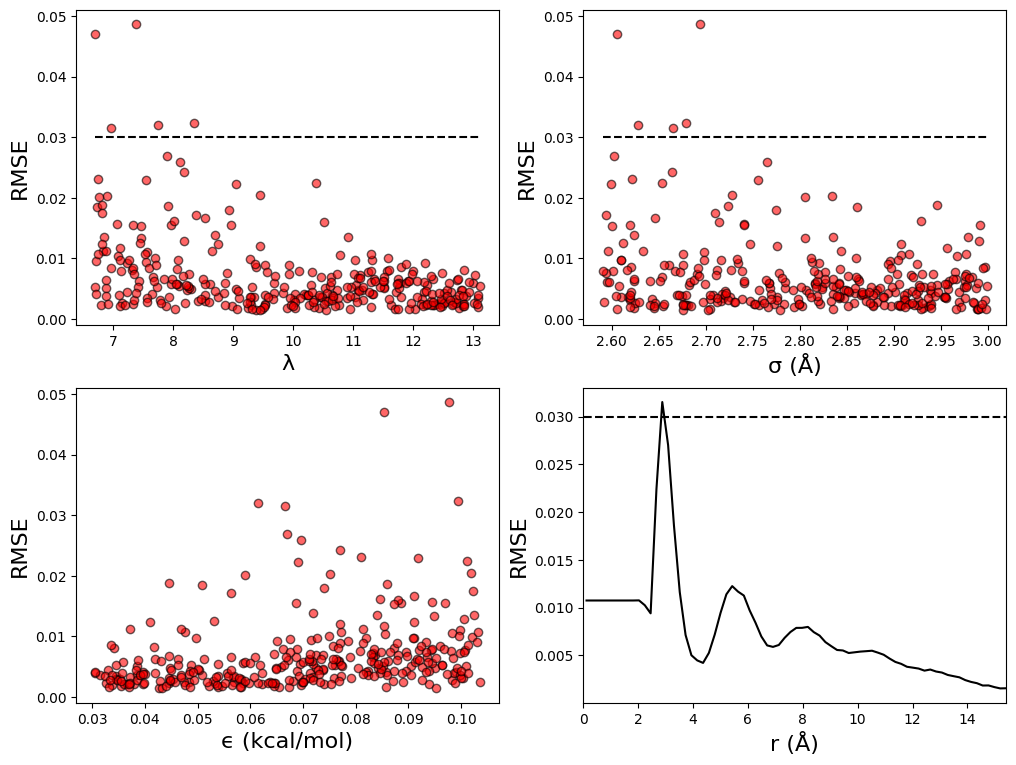

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(12, 9))
axs[0,0].scatter(xs_test[:,0], err, color = 'r', alpha = 0.6, edgecolors = 'k')
axs[0,0].hlines(0.03,xmin=min(xs_test[:,0]),xmax=max(xs_test[:,0]),color='k',linestyle='dashed')
axs[0,0].set_xlabel('λ', fontsize = 16)
axs[0,0].set_ylabel('RMSE', fontsize = 16)
#axs[0,0].text(10.8, 0.076, '(a)', fontsize = 16)
axs[0,1].hlines(0.03,xmin=min(xs_test[:,1]),xmax=max(xs_test[:,1]),color='k',linestyle='dashed')
axs[0,1].scatter(xs_test[:,1], err, color = 'r', alpha = 0.6, edgecolors = 'k')
axs[0,1].set_xlabel('σ (Å)', fontsize = 16)
axs[0,1].set_ylabel('RMSE', fontsize = 16)
#axs[0,1].text(2.92, 0.076, '(b)', fontsize = 16)
axs[1,0].scatter(xs_test[:,2], err, color = 'r', alpha = 0.6, edgecolors = 'k')
#axs[1,0].hlines(0.03,xmin=min(xs_test[:,2]),xmax=max(xs_test[:,2]),color='k',linestyle='dashed')
axs[1,0].set_xlabel('ϵ (kcal/mol)', fontsize = 16)
axs[1,0].set_ylabel('RMSE', fontsize = 16)
#axs[1,0].text(0.087, 0.076, '(c)', fontsize = 16)
#axs[1,1].plot(r,RMSE, color = 'k', label = 'Mean', linestyle = '-')
axs[1,1].plot(r,RMSE, color = 'k', label = 'Mean', linestyle = '-')
axs[1,1].set_xlim(0, r[-1])
axs[1,1].set_xlabel('r (Å)', fontsize = 16)
axs[1,1].set_ylabel('RMSE', fontsize = 16)
axs[1,1].hlines(0.03,xmin=rmin,xmax=rmax,color='k',linestyle='dashed')
#axs[1,1].text(13.6, 0.095, '(d)', fontsize = 16)
# plt.savefig('rmse', dpi = 600)
plt.show()

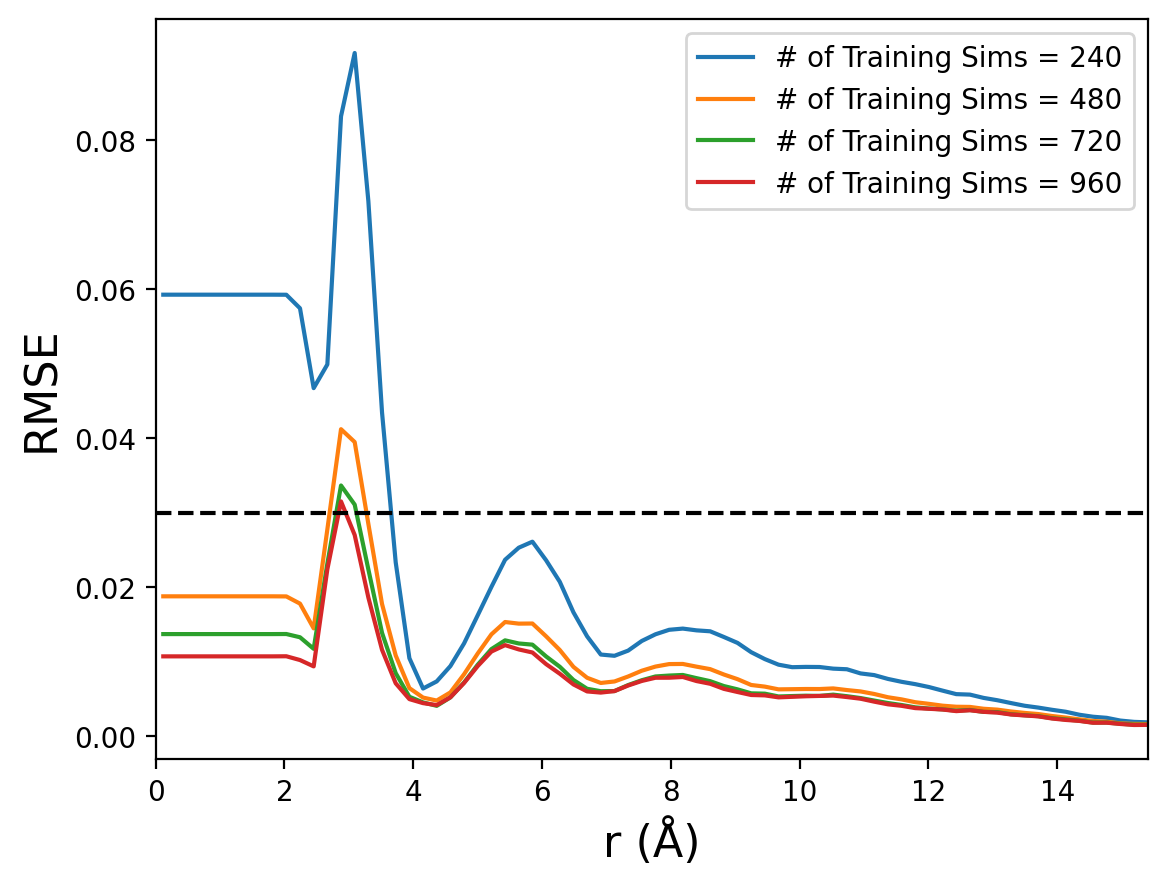

In [106]:
plt.figure()
for i in range (len(sim_numbers)):
    RMSEnums = torch.zeros(73)
    Xd_cut = list()
    Xd_cut.append(Xd[0:sim_numbers[i]])
    Xd_cut.append(Xd[320:320 + sim_numbers[i]])
    Xd_cut.append(Xd[640:640 + sim_numbers[i]])
    merged = torch.tensor(np.array(list(itertools.chain(*Xd_cut))))
    y_cut = list()
    y_cut.append(y[0:sim_numbers[i]])
    y_cut.append(y[320:320 + sim_numbers[i]])
    y_cut.append(y[640:640 + sim_numbers[i]])
    mergedy = torch.tensor(np.array(list(itertools.chain(*y_cut))))
    Kdd = se_kernel(merged,merged,l,w) + torch.eye(len(merged))*σn
    Kid = se_kernel(Xi, merged, l, w)
    KddInv = torch.linalg.inv(Kdd)
    Xi = xs_test.float()
    GPOut = local_surrogate(Xi, merged, l, w, mergedy, KddInv)
    RMSEnums = torch.sqrt(torch.mean((GPOut.T - rdfs_test_bruh)**2,dim=0))
    plt.plot(r, RMSEnums, label = '# of Training Sims = ' + str(int(sim_numbers[i])*3), linestyle = '-')
plt.xlim(0, r[-1])
plt.xlabel('r (Å)', fontsize = 16)
plt.ylabel('RMSE', fontsize = 16)
plt.hlines(0.03,xmin=rmin,xmax=rmax,color='k',linestyle='dashed')
plt.legend()
plt.savefig('figures/rmsevssims', dpi = 600)
plt.show()
    

In [ ]:
for i in torch.argsort(err)[-5:]:
    plt.plot(r,GPOut.T[i],label="LGP Model")
    plt.plot(r,rdfs_test[i],label="True")
    plt.title(xs_test[i])
    plt.legend()
    plt.show()

In [ ]:
plt.xlim(2.6, 3.8)
plt.ylim(1,2.1)
plt.xlabel('r (Å)', fontsize = 16)
plt.ylabel('RMSE', fontsize = 16)
plt.plot(r, rdf_exp)
plt.plot(r,rdf_exp+0.03,color='k',linestyle='dashed',alpha=0.5)
plt.plot(r,rdf_exp-0.03,color='k',linestyle='dashed',alpha=0.5)
plt.fill_between(r,rdf_exp-RMSE,rdf_exp+RMSE,color='orange',alpha=0.5)
plt.show()

## Timing Code

In [ ]:
try:
    input_dict = load(open('training_data/ClassicGPTimesRDF', 'rb'))
    evaluationTimesClassic = input_dict['evaluationTimesClassic']
    inversionTimesClassic = input_dict['inversionTimesClassic']

    print("Loaded previously computed times..")
    
    print("Average inversion time for classic GP:", np.mean(inversionTimesClassic))
    print()

    print("Average evaluation time for classic GP:", np.mean(evaluationTimesClassic))
    print()
    
# Get time taken for regualar GP
except:
    evaluationTimesClassic = [] 
    inversionTimesClassic = []
    N_trialsClassic = 20
    
    print("Timing Kdd inversion...")
    
    for n in range(N_trialsClassic):
        
        t1 = time.time()
        
        # No need to apply good hps here, we only care about the time
        KddClassic = se_kernel(XdClassic,XdClassic,torch.ones(len(XdClassic[0])),1) + 2*torch.eye(len(XdClassic))
        KddInvClassic = torch.linalg.inv(KddClassic)
        
        t2 = time.time()
        
        inversionTimesClassic.append(t2-t1)
    print("Average inversion time for classic GP:", np.mean(inversionTimesClassic))
    print()
    
    print("Timing surrogate evaluation...")

    Xi = XdClassic[:len(r)]
    
    for n in range(N_trialsClassic):
        
        t1 = time.time()
        
        μ = surrogate(Xi,XdClassic,torch.ones(len(XdClassic[0])),1,yClassic,KddInvClassic)
        
        t2 = time.time()
        
        evaluationTimesClassic.append(t2-t1)
        
    print("Average evaluation time for classic GP:", np.mean(evaluationTimesClassic))
    print()

    from pickle import dump
    output_dict = dict(evaluationTimesClassic = evaluationTimesClassic, inversionTimesClassic = inversionTimesClassic)
    dump(output_dict, open('training_data/ClassicGPTimesRDF', 'wb'))

In [ ]:
try:
    input_dict = load(open('training_data/SubsetGPTimesRDF', 'rb'))
    evaluationTimesSubset = input_dict['evaluationTimesSubset']
    inversionTimesSubset = input_dict['inversionTimesSubset']

    print("Loaded previously computed times..")
    print()
    
    print("Average inversion time for subset GP:", np.mean(inversionTimesSubset))
    print()

    print("Average evaluation time for subset GP:", np.mean(evaluationTimesSubset))
    print()

# Get time taken for subset GP
except:
    
    evaluationTimesSubset = [] 
    inversionTimesSubset = []
    
    N_trials = 1000
    
    print("Timing Kdd inversion...")
    for n in range(N_trials):
        
        t1 = time.time()

        KddSubset = se_kernel(XdSubset,XdSubset,lSubset,wSubset) + σnSubset*torch.eye(len(XdSubset))
        KddInvSubset = torch.linalg.inv(KddSubset)
        
        t2 = time.time()
        
        inversionTimesSubset.append(t2-t1)
    print("Average inversion time for subset GP:", np.mean(inversionTimesSubset))
    print()

    XiSubset = torch.tensor([[XdSubset[0][0],XdSubset[0][1],XdSubset[0][2]]])
    
    print("Timing surrogate evaluation...")
    for n in range(N_trials):
        
        t1 = time.time()
        
        μ = subset_surrogate(XiSubset,XdSubset,lSubset,wSubset,ySubset,KddInvSubset)
        
        t2 = time.time()
        
        evaluationTimesSubset.append(t2-t1)
        
    
    print("Average evaluation time for subset GP:", np.mean(evaluationTimesSubset))
    print()

    from pickle import dump
    output_dict = dict(evaluationTimesSubset = evaluationTimesSubset, inversionTimesSubset = inversionTimesSubset)
    dump(output_dict, open('training_data/SubsetGPTimesRDF', 'wb'))

In [ ]:
numMCMCSamps = 12_000
numGridSamps = 50**4
# Note these assume no overhead. 
print("Expected time for model calls during MCMC with subset: " + str(np.round(numMCMCSamps*np.mean(evaluationTimesSubset)/60,4)) +  " Mins")
print("Expected time for model calls during MCMC with regular gp: " + str(np.round(numMCMCSamps*np.mean(evaluationTimesClassic)/60,4)) +  " Mins")
print()
print("Expected time for model calls for grid with subset: " + str(np.round(numGridSamps*np.mean(evaluationTimesSubset)/60/60,4)) +  " Hours")
print("Expected time for model calls for grid with regular gp: " + str(np.round(numGridSamps*np.mean(evaluationTimesClassic)/60/60,4)) + " Hours")
print()
print("Evaluation Speed up Classic vs Subset:", np.mean(evaluationTimesClassic)/np.mean(evaluationTimesSubset))
print("Inversion Speed up Classic vs Subset:", np.mean(inversionTimesClassic)/np.mean(inversionTimesSubset))
print("Evaluation Speed up Classic vs Sim:", 86.2483875498 /np.mean(evaluationTimesClassic))
print("Evaluation Speed up Subset vs Sim:", 86.2483875498 /np.mean(evaluationTimesSubset))
print()